# Anime Classifier

In [41]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
import albumentations as A
import numpy as np
import random
import torch
from torch import nn
import pandas as pd
import time
import matplotlib.pyplot as plt
from torchvision import models
from glob import glob
from torch.utils.data import random_split, Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
import json
import cv2

### Определяем девайс и путь к файлам

In [42]:
data_path = './data/one-piece-classification/'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Читаем лейблы

In [43]:
with open(f'{data_path}labels.json', encoding='UTF-8') as file_in:
    labels = json.load(file_in)
labels = {int(key): value for key, value in labels.items()}
labels

{0: 'Ace',
 1: 'Akainu',
 2: 'Brook',
 3: 'Chopper',
 4: 'Crocodile',
 5: 'Franky',
 6: 'Jinbei',
 7: 'Kurohige',
 8: 'Law',
 9: 'Luffy',
 10: 'Mihawk',
 11: 'Nami',
 12: 'Rayleigh',
 13: 'Robin',
 14: 'Sanji',
 15: 'Shanks',
 16: 'Usopp',
 17: 'Zoro'}

### Количество классов

In [44]:
num_classes = len(labels)
num_classes

18

### Пишем свой класс датасета

In [45]:
class AnimeDataset(Dataset):
    def __init__(self, mode = 'train', transformations = None):
        assert mode in ('train', 'test')
        self.mode = mode
        self.transformations = transformations
        
        if self.mode == 'train':
            annotations = pd.read_csv(f'{data_path}train_annotations.csv')
            self.ids = annotations['id'].to_list()
            self.labels = annotations['label'].to_list()
            self.paths = annotations['image_path'].apply(lambda x: data_path + 'splitted/' + x.replace('\\', '/')).to_list()
            
        elif self.mode == 'test':
            self.paths = [path for path in glob(f'{data_path}splitted/test/*.*')]
            self.ids = [path.split('\\')[1].split('.')[0] for path in self.paths]
            
    def __len__(self): 
        return len(self.paths)
    
    def __getitem__(self, idx):
        image = cv2.cvtColor(cv2.imread(self.paths[idx], cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
        if self.transformations: 
            transformed = self.transformations(image=image)
            image = transformed["image"].to(device)
        if self.mode == 'train':
            return image, torch.tensor(self.labels[idx], device=device), self.ids[idx]
        elif self.mode == 'test':
            return image, self.ids[idx]

### Определяем трансформы

In [46]:
im_h, im_w = 128, 128
# у нас все-таки аниме, а не фотки так что коэффициенты посчитаем сами
# default: mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
mean, std = [0.5734, 0.5229, 0.4958], [0.2700, 0.2644, 0.2669]

# Первый набор аугментаций, тут нет ничего что сильно бы меняло картинку
# на нем модель учится быстрее, но сильнее переобучается
transformations1 = A.Compose( [
    A.Resize(im_h, im_w),
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(),
    A.augmentations.transforms.Normalize(mean=mean, std=std),
    # A.ToFloat(),
    ToTensorV2(transpose_mask = True)
])

# Второй набор аугментаций, содержащий более продвинутые аугментации
# на нем модель учится медленнее, но меньше переобучается
transformations2 = A.Compose( [
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15),
    A.Resize(im_h, im_w),
    A.HorizontalFlip(),
    A.CoarseDropout(max_holes=4, max_height=8, max_width=8),
    A.OpticalDistortion(),
    A.RandomBrightnessContrast(),
    A.augmentations.transforms.Normalize(mean=mean, std=std),
    # A.ToFloat(),
    ToTensorV2(transpose_mask = True)
])
# Зачем все это придумано будет описано ниже

train_dataset = AnimeDataset(mode='train', transformations=transformations1)
train_dataset2 = AnimeDataset(mode='train', transformations=transformations2)
test_dataset = AnimeDataset(mode='test', transformations=transformations1)

### Считаем вручную mean & std

In [47]:
# means = torch.zeros(3)
# stds = torch.zeros(3)
# for i in range(len(train_dataset)):
#     std, mean = torch.std_mean(train_dataset[i][0], dim=(1, 2))
#     means += mean
#     stds += std
# means /= len(train_dataset)
# stds /= len(train_dataset)
# display(means, stds)

### Функции для рисования примеров картинок

In [48]:
def plot(rows, cols, count, im, gt = None, title = "Original Image"):
    plt.subplot(rows, cols, count)
    image = im.squeeze(0).permute(1,2,0) if not gt else im.squeeze(0).float()
    plt.imshow(image)
    plt.axis("off"); plt.title(title)
    return count + 1

def visualize(ds, n_ims):
    plt.figure(figsize = (25, 20))
    rows = n_ims // 4; cols = n_ims // rows
    count = 1
    indices = [random.randint(0, len(ds)) for _ in range(n_ims)]
    for idx, index in enumerate(indices):
        if count == n_ims + 1: break
        im, label, _ = ds[index]
        count = plot(rows, cols, count, im = im.cpu().clip(0, 1), title=labels[label.cpu().item()])

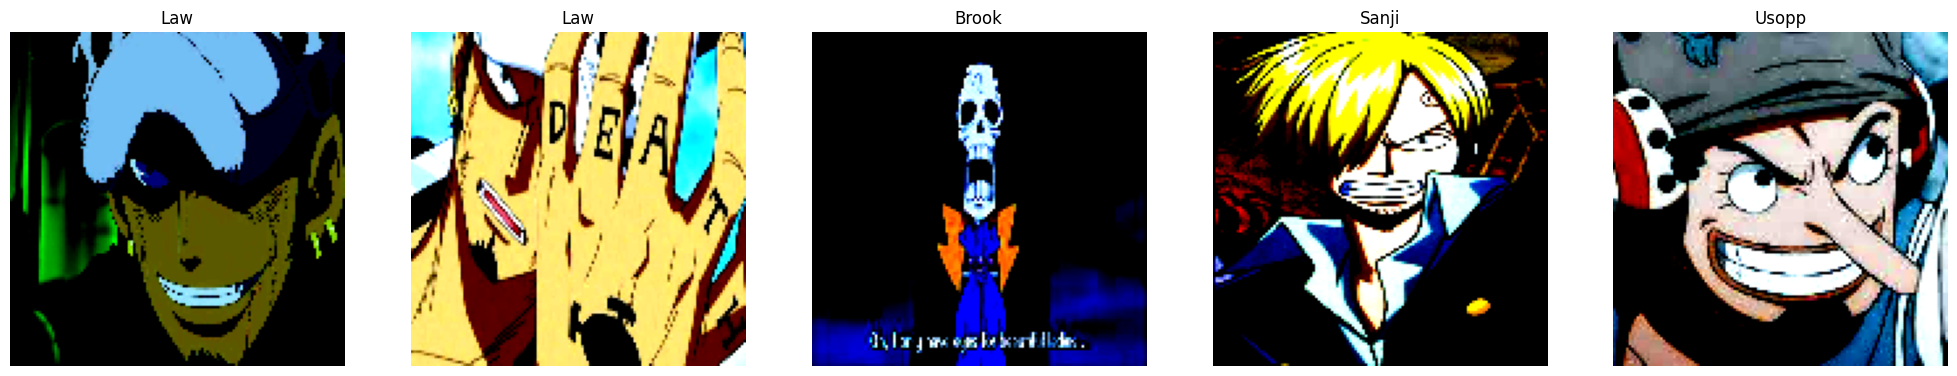

In [49]:
visualize(train_dataset, 5)

### Делаем сплит и даталоадеры

In [50]:
split = [0.9, 0.1]
batch_size = 32

# создайте датасеты для теста и валидации

train_len = int(len(train_dataset) * split[0])
val_len = len(train_dataset) - train_len

# Data split
generator = torch.Generator().manual_seed(666)
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_len, val_len], generator)
generator = torch.Generator().manual_seed(666)
train_dataset2, _ = torch.utils.data.random_split(train_dataset2, [train_len, val_len], generator)

print(f"\nThere are {len(train_dataset)} of images in the train set")
print(f"There are {len(val_dataset)} of images in the validation set")
print(f"There are {len(test_dataset)} of images in the test set\n")

# Get dataloaders
train_dataloader  = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle = True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle = False)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=1, shuffle = False)

noisy_train = DataLoader(dataset=train_dataset2, batch_size=batch_size, shuffle = True)


There are 2624 of images in the train set
There are 292 of images in the validation set
There are 849 of images in the test set



### Я честно пытался сделать свою модель, но работали они не очень хорошо

### Поэтому...

In [52]:
model = models.resnext101_64x4d(weights='ResNeXt101_64X4D_Weights.DEFAULT')

#### О выбранной модели
##### Как ясно из названия, ResNeXt - доработка ResNet. Архитектура модели была представлена в 2017 году (ниже ссылка на статью). \
##### Идея заключается в модификации базового блока ResNet, как представлено на картинке ниже. ResNeXt использует значительно более узкий bottleneck, но зато идет несколькими путями.
![alt text](resnext.png) \
##### При почти одинаковом количестве параметров, модель превосходит по точности (ImageNet) обычный ResNet \
![alt text](resnetvsresnext.png) \
##### Выбранная модель, ResNeXt101_64X4D превосходит по точности на ImageNet даже 200-слойный ResNet \
![alt text](resnet10164x4dperformance.png) \
[Ссылка на оригинальную статью](https://arxiv.org/abs/1611.05431)

### Меняем последний слой на 18 классов

In [53]:
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)
model = model.to(device)

### Определяем лоссы и оптимизатор

In [54]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

### Итерация train

In [55]:
def train(dataloader, model, criterion, optimizer):
    start_time = time.time()
    num_batches = len(dataloader)
    all_losses = []
    avg_loss = 0
    model.train()
    for batch_idx, (inputs, targets, _) in enumerate(dataloader):

        # Compute prediction error
        preds = model(inputs)
        loss = criterion(preds, targets)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        all_losses.append(loss.item())
        avg_loss += loss.item()
    
    avg_loss /= num_batches
    end_time = time.time()
    print(f'Train Loss: {avg_loss:>4f}, Iter time: {round(end_time - start_time, 2)}s')
    return all_losses, avg_loss

### Итерация eval

In [56]:
def eval(dataloader, model, criterion, scheduler=None):
    num_batches = len(dataloader)
    model.eval()
    avg_loss = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets, _ in dataloader:
            preds = model(inputs)
            avg_loss += criterion(preds, targets).item()
            
            # Store predictions and targets for metrics computation
            all_preds.extend(preds.argmax(1).cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    avg_loss /= num_batches
    # scheduler.step(avg_loss)    
    
    # Compute acc, precision and recall
    accuracy = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds, average='weighted', zero_division=np.nan)
    recall = recall_score(all_targets, all_preds, average='weighted', zero_division=np.nan)
    
    print(f'Test Loss: {avg_loss:>4f}')
    # print(f'Test Loss: {avg_loss:>4f}, LR: {scheduler.get_last_lr()[0]}')
    print(f'Accuracy: {100*accuracy:>0.01f}%, Precision: {100*precision:>0.01f}%, Recall: {100*recall:>0.01f}%')

    return avg_loss, accuracy, precision, recall

### Лоссы будем записывать в отдельные списки чтоб не терять их историю при дообучении

In [57]:
all_losses = []
train_losses = []
eval_losses = []
accuracies = []
precisions = []
recalls = []

### При необходимости выступаем в роли планировщика

In [139]:
optimizer.param_groups[0]['lr'] = 1e-7

### Или играемся с размером батча

In [ ]:
noisy_train = DataLoader(dataset=train_dataset2, batch_size=64, shuffle = True)
train_dataloader  = DataLoader(dataset=train_dataset, batch_size=64, shuffle = True)

#### В чем идея двух трейн датасетов с разными аугментациями?
##### Учить модель на датасете с продвинутыми аугментациями долго (долго сходится), в чем я лично убедился. А с не очень продвинутыми быстро, но упираемся в определенный потолок, вероятно, из-за переобучения. Поэтому я сначала обучил модель на обычном датасете, после чего дообучал ее на более шумном (и иногда вновь менял их местами), постепенно понижая lr по мере увеличения точности и столкновения с очередным потолком. Также я играл с размером по мере обучения, но не знаю дало ли это что-нибудь существенное.

### Обучение

In [193]:
epochs = 1

start_time = time.time()
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    # noisy_train, train_dataloader
    losses, train_loss = train(train_dataloader, model, criterion, optimizer)
    eval_loss, accuracy, precision, recall = eval(val_dataloader, model, criterion)
    end_time = time.time()
    print(f'Elapsed time: {round(end_time - start_time, 2)}s')
    
    all_losses.extend(losses)
    train_losses.append(train_loss)
    eval_losses.append(eval_loss)
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)

Epoch 1
-------------------------------
Train Loss: 0.000364, Iter time: 36.5s
Test Loss: 0.140081
Accuracy: 96.2%, Precision: 96.5%, Recall: 96.2%
Elapsed time: 39.15s


In [186]:
def visualize_errors(ds, n_ims):
    plt.figure(figsize = (25, 20))
    rows = n_ims // 4; cols = n_ims // rows
    count = 1
    errors = []
    with torch.no_grad():
        for i in range(len(ds)):
            if len(errors) == n_ims:
                break
            image, label, id = ds[i]
            pred = model(image.unsqueeze(0)).argmax(1).cpu().item()
            if pred != label:
                errors.append([i, pred])
            
    for idx, (index, predict) in enumerate(errors):
        if count == n_ims + 1: break
        im, label, id = ds[index]
        count = plot(rows, cols, count, im = im.cpu().clip(0, 1), title=f'True: {labels[label.item()]}, Predicted: {labels[predict]}')

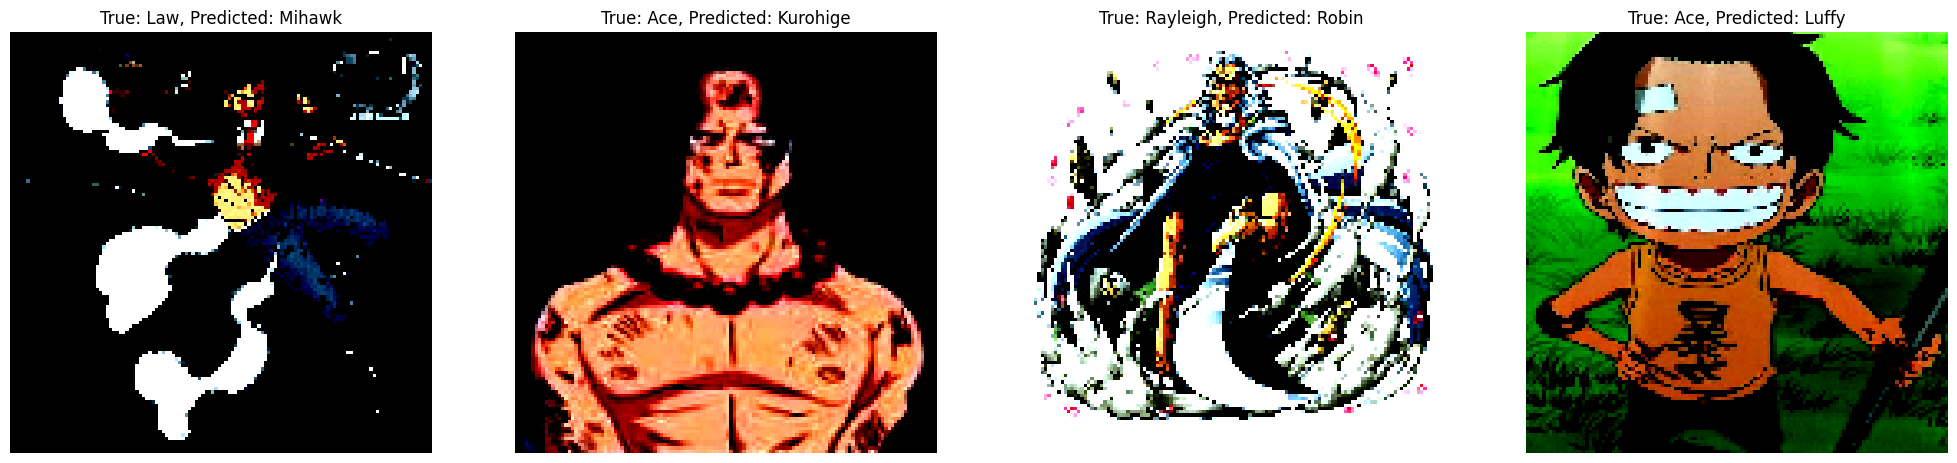

In [194]:
visualize_errors(val_dataset, 4)

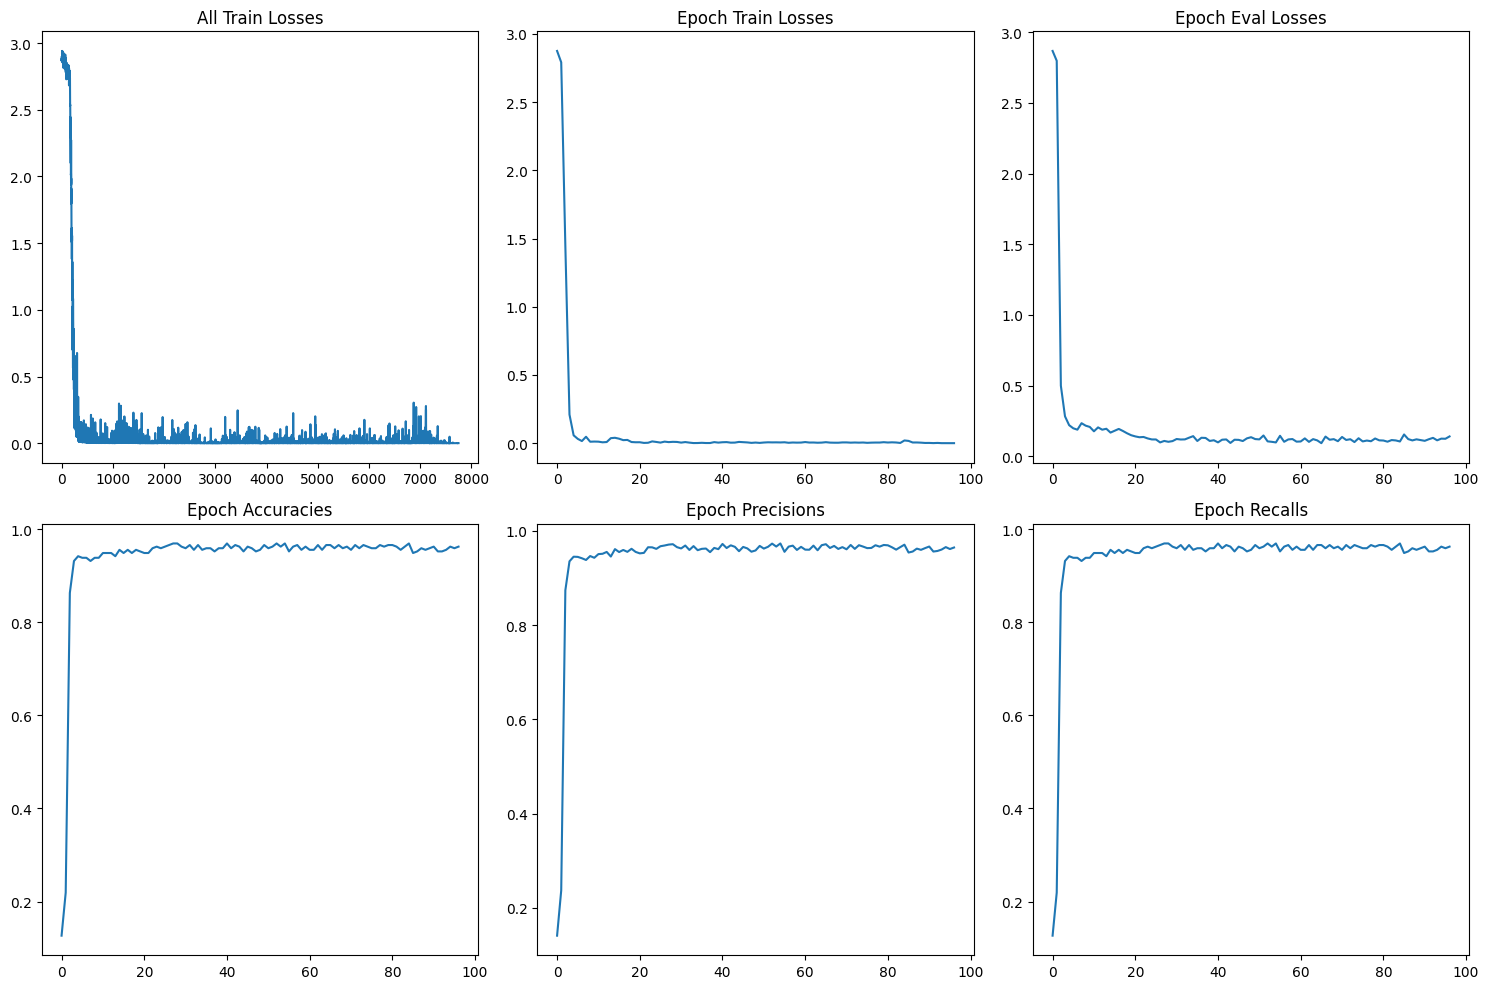

In [195]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes[0,0].plot(all_losses)
axes[0,0].set_title('All Train Losses')
axes[0,1].plot(train_losses)
axes[0,1].set_title('Epoch Train Losses')
axes[0,2].plot(eval_losses)
axes[0,2].set_title('Epoch Eval Losses')
axes[1,0].plot(accuracies)
axes[1,0].set_title('Epoch Accuracies')
axes[1,1].plot(precisions)
axes[1,1].set_title('Epoch Precisions')
axes[1,2].plot(recalls)
axes[1,2].set_title('Epoch Recalls')
plt.tight_layout()
plt.show()

### Сохраняем веса (к сожалению 300мб а не 5)

In [196]:
# torch.save(model.state_dict(), './models/anime_resnext101_3.pth')

### Функция получающая датафрейм предиктов

In [197]:
def get_test_preds(model, dataloader):
    submission = pd.DataFrame(columns=['id', 'label'])
    model.eval()
    with torch.no_grad():
        for index, (input, id) in enumerate(dataloader):
            pred = model(input)
            pred = pred.argmax(1).cpu().item()
            submission.loc[index] = [id[0], pred]
    return submission

In [198]:
submission = get_test_preds(model, test_dataloader)
submission

,id,label
0,002999fb-803d-45b2-b647-6203e446e475,2
1,00479183-ca4e-49c1-927d-f7209ff23145,11
2,0048719e-24d9-4a5a-af75-ca62c2e90477,8
3,00c99fe0-e1c9-48ef-8d16-1ea380f190cd,6
4,00efbf59-d4c4-4d7e-8bc6-86af36367515,10
...,...,...
844,fe669d74-9668-4f48-b560-690303ad9645,10
845,fe80fd31-7221-46b8-9667-8f4292a899c3,1
846,fedb066e-a7ca-4c22-8bb1-77e7f130b441,2
847,ff29f8d5-6e47-4136-b43d-2f88d38dd509,1


In [199]:
submission['label'].value_counts()

label
4     54
12    53
1     53
11    52
13    50
5     50
10    48
0     48
6     47
3     47
2     46
15    46
7     46
16    45
14    44
8     42
17    41
9     37
Name: count, dtype: int64

### Визуализация предиктов

In [200]:
def visualize_predicts(ds, n_ims):
    plt.figure(figsize = (25, 20))
    rows = n_ims // 4; cols = n_ims // rows
    count = 1
    indices = [random.randint(0, len(ds)) for _ in range(n_ims)]
    for idx, index in enumerate(indices):
        if count == n_ims + 1: break
        im, id = ds[index]
        label = submission[submission['id'] == id]['label'].to_numpy()[0]
        count = plot(rows, cols, count, im = im.cpu().clip(0, 1), title=labels[label])

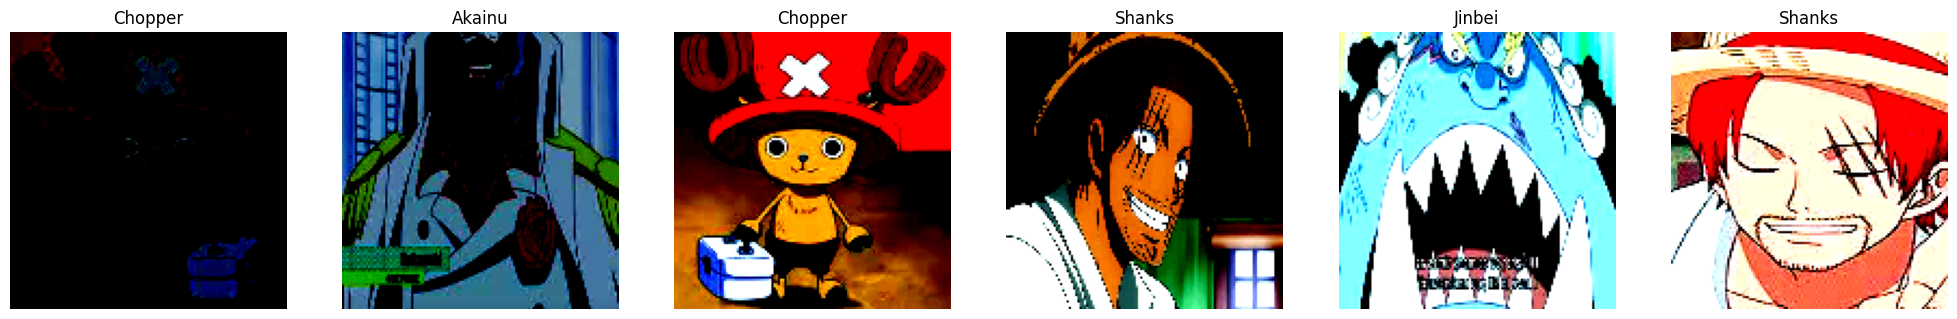

In [201]:
visualize_predicts(test_dataset, 6)

### Я конечно не эксперт в ванписе, но похоже на правду

### Сохраняем сабмит

In [202]:
submission.to_csv('submit_2.csv', index=False)